In [38]:
import sys
import random
import cv2

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# image import
src = cv2.imread('namecard1.jpg')

if src is None:
    print('IMAGE LOAD FAILED')
    sys.exit()

In [5]:
# convert to grayscale
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)


$I(x,y) = \left\{
    \begin{array}{ll}
        255 & \text{if } I(x,y) > T \\
        0 & \text{otherwise}
    \end{array}
\right.$

where 
- $I$: intensity at coordinates $(x, y)$ 
- $T$: threshold

In opencv, $T$ is calculated using the Otsu method:

The between-class variance $\sigma_{B}^{2}(t)$ at threshold $t$ is defined as:

$$
\sigma_{B}^{2}(t) = \omega_{0}(t) \cdot \omega_{1}(t) \cdot (\mu_{0}(t) - \mu_{1}(t))^2
$$

where:

- $\omega_{0}(t)$ and $\omega_{1}(t)$ are the probabilities of the two classes separated by threshold $t$.
- $\mu_{0}(t)$ and $\mu_{1}(t)$ are the mean intensity values of these two classes.

The optimal threshold $t^*$ is the value that maximizes $\sigma_{B}^{2}(t)$:

$$
t^* = \underset{t}{\mathrm{argmax}}\ \sigma_{B}^{2}(t)
$$



In [6]:
# auto binarization (formula above)
_, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

In [7]:
print(_)

133.0


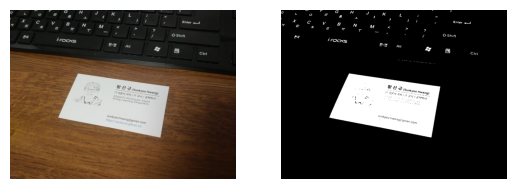

In [10]:
# visualization

# cv2.imshow('src', src)
# cv2.imshow('src_bin', src_bin)
# cv2.waitKey(3)
# cv2.destroyAllWindows()

plt.subplot(121)
plt.axis('off')
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.axis('off')
plt.imshow(cv2.cvtColor(src_bin, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
# object countour tracing
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [14]:
# convert binarizaed image to color
dst = cv2.cvtColor(src_bin, cv2.COLOR_GRAY2BGR)

In [19]:
# draw boundaries
for i in range(len(contours)):
    c = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
    cv2.drawContours(dst, contours, i, c, 2)

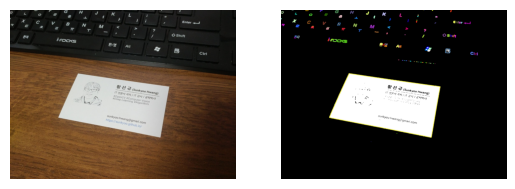

In [20]:
# visualize
plt.subplot(121)
plt.axis('off')
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.axis('off')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()


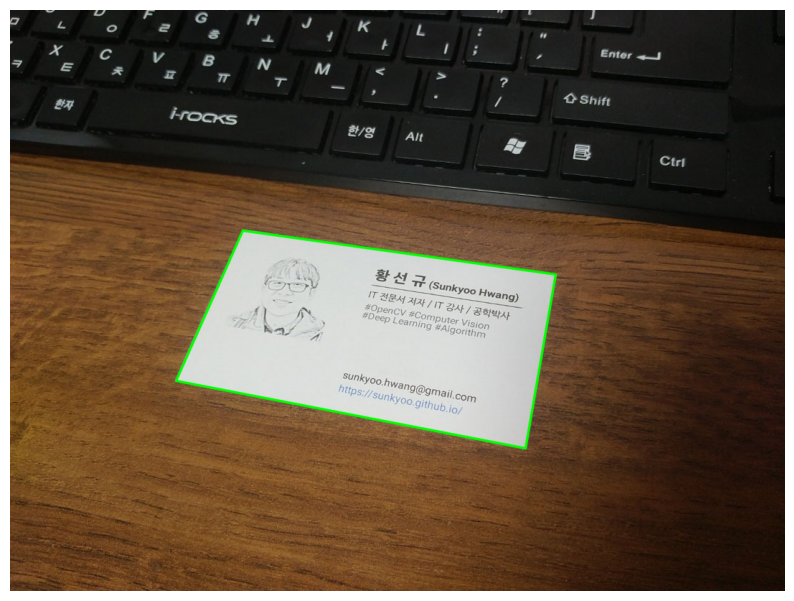

In [22]:
# detect businesscard (using approximation)
for pts in contours:
    # ignore small objects
    if cv2.contourArea(pts) < 1000:
        continue

    # contour approximation
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    # display contour for square object
    if len(approx) == 4:
        cv2.polylines(src, [approx], True, (0,255,0), 2, cv2.LINE_AA)

# visualize
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.show()




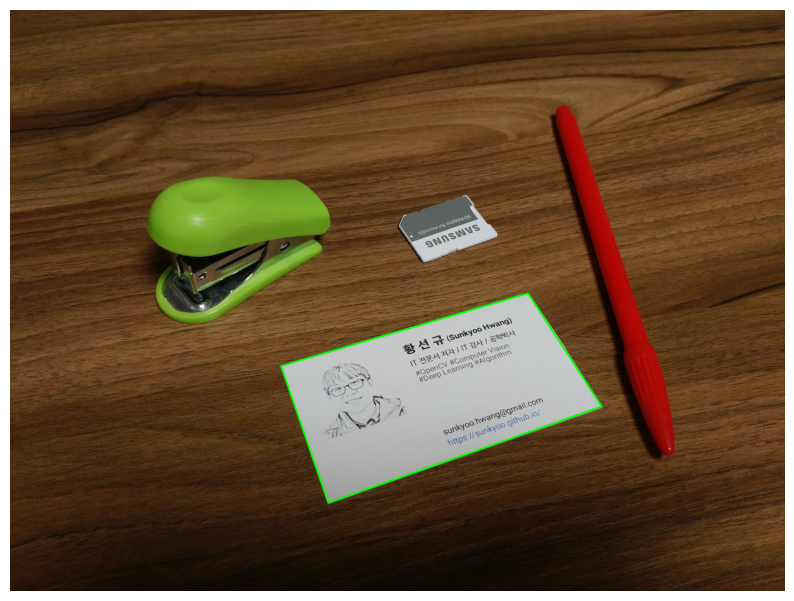

In [27]:
# try different image

src2 = cv2.imread('namecard2.jpg')
src2_gray = cv2.cvtColor(src2, cv2.COLOR_BGR2GRAY)
_, src_bin2 = cv2.threshold(src2_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
contours2, _ = cv2.findContours(src_bin2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# detect businesscard (using approximation)
for pts in contours2:
    # ignore small objects
    if cv2.contourArea(pts) < 1000:
        continue

    # contour approximation
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    # display contour for square object
    if len(approx) == 4:
        cv2.polylines(src2, [approx], True, (0,255,0), 2, cv2.LINE_AA)

# visualize
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cv2.cvtColor(src2, cv2.COLOR_BGR2RGB))
plt.show()





In [41]:
# perspective transformation

w, h = 720, 400
srcQuad = np.array([[324,308], [760,369], [718,611], [231, 517]], np.float32)
dstQuad = np.array([[0,0], [w-1, 0], [w-1, h-1], [0, h-1]], np.float32)
dst = np.zeros((h, w), np.uint8)

pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(src, pers, (w,h))


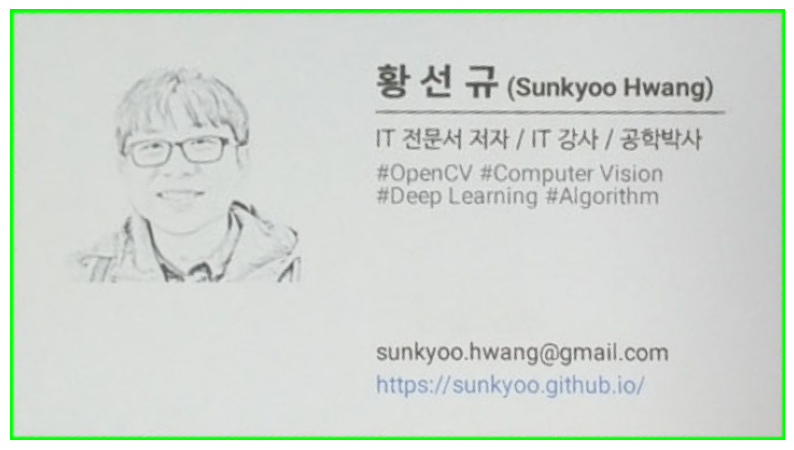

In [43]:
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

In [44]:
# perspective transformation: more fine-tuned

def reorderPts(pts):
    # Sort the points based on x-coordinates, and then by y-coordinates
    idx = np.lexsort((pts[:, 1], pts[:, 0]))  # Return indices that would sort the array first by y, then by x.
    pts = pts[idx]  # Reorder points according to the sorted indices.

    # Ensure the points are ordered in top-left, bottom-left order
    if pts[0, 1] > pts[1, 1]:
        pts[[0, 1]] = pts[[1, 0]]  # Swap first and second point if the first point is not the upper one.

    # Ensure the points are ordered in top-right, bottom-right order
    if pts[2, 1] < pts[3, 1]:
        pts[[2, 3]] = pts[[3, 2]]  # Swap the third and fourth point if the third is not the lower one.

    return pts  # Return the reordered points.



In [45]:

w, h = 720, 400
srcQuad = np.array([[0,0], [0,h], [w,h], [w, 0]], np.float32)
dstQuad = np.array([[0,0], [0, h], [w, h], [w, 0]], np.float32)
dst = np.zeros((h, w), np.uint8)

# convert to grayscale
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# auto binarization
_, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# contour tracing
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# approximate
for pts in contours:
    # ignore small objects
    if cv2.contourArea(pts) < 1000:
        continue

    # contour approximation
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    # display contour for square object
    if len(approx) == 4:
        # cv2.polylines(src, [approx], True, (0,255,0), 2, cv2.LINE_AA)
        corners = approx.reshape(4,2).astype(np.float32)
        srcQuad = reorderPts(corners)

pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(src, pers, (w,h))

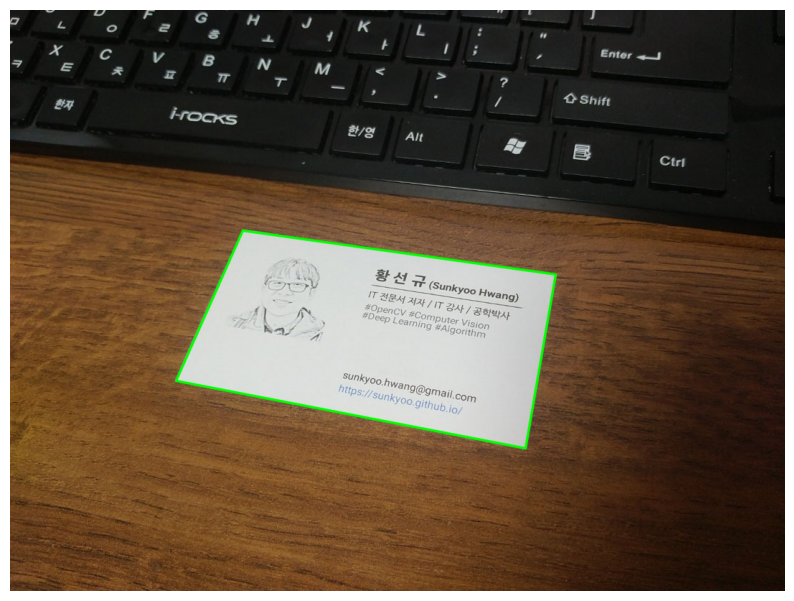

In [46]:
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.show()

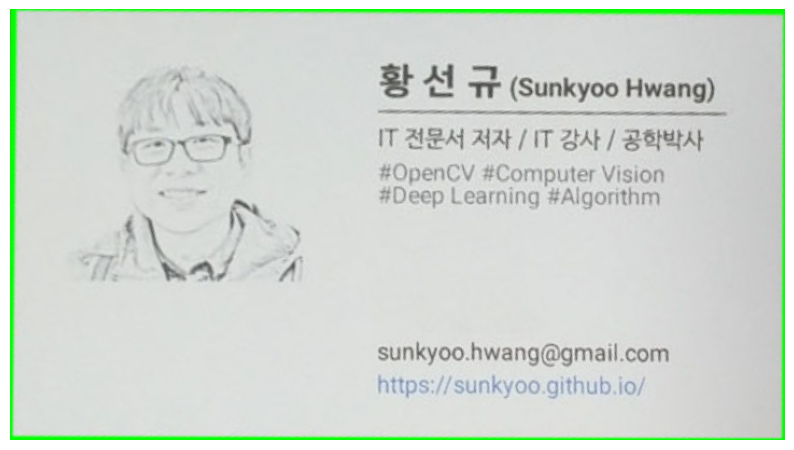

In [47]:
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()